# Importo y defino todo 

In [1]:
!pip install fermat

In [2]:
import fermat as F
import numpy as np
import scipy.sparse as sp
import time
from scipy.spatial import  distance_matrix
from sklearn.manifold import TSNE
from scipy.optimize import minimize
from sklearn.neighbors import KDTree
from scipy.optimize import LinearConstraint
from scipy.sparse import csr_matrix
from scipy.spatial.distance import pdist,cdist, squareform
import scipy
import warnings 
warnings.filterwarnings('ignore')​

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def cero(a,b):
  return 0, np.zeros(a.shape)

importe lo necesario y armo las funciones que me dicen el costo de transportar una serie de puntos con fermat dada la matriz de distancias de fermat (lo que usaba en transporte optimo antes), tambien hago su gradiente y pruebo

In [3]:
#Builds fermat graph given data, alpha, method (and if 'D' is chosen with k_fermat neighbours)
#RETURNS: fermat distance matrix between points of data and a KD-Tree 


def fermat_graph(data,alpha,method='FW',k_fermat=30):
    model=F.Fermat(alpha, path_method=method,k=k_fermat)
    model.fit(np.matrix(distance_matrix(data,data)))
    fermat_distances = model.get_distances()
    tree = KDTree(data)
    return fermat_distances,tree
              

#Computes fermat_cost of transporting initialData to x with the given fermat_distances
#initial data will be points

#It uses the KD-Tree built with fermat_graph() as well as a parameter 'k' which is 
#the amount of neighbours to look at when getting the fermat distance for a point that
#is not in the graph (including it may be computationally expensive)
#It also recieves the original data and the alpha used to build fermat_distances
              
#RETURNS: fermat cost and gradient of that cost
def fermat_cost_cuad(x,initialData,dimension,fermat_distances,tree,data,k,alpha):
    assert(len(x)==(initialData.shape[0])*dimension)
    real_x=x.reshape(-1,dimension)     
    res=0
    gradient=np.zeros(x.shape)
    for i in range(initialData.shape[0]):
        dist,grad_idx=fermat_dist(initialData[i,:],real_x[i,:],fermat_distances,tree,k,alpha) 
        q=data[grad_idx,:] 
        local_grad=alpha*(np.linalg.norm(q-real_x[i,:])**(alpha-2))*(real_x[i,:]-q)*2*dist
        res+=dist**2              
        gradient[dimension*i:dimension*(i+1)]=local_grad
    return res,gradient
#ojoo cambie para la DISTANCIA AL CUADRADO!! 



#RETURNS: fermat cost and gradient of that cost
def fermat_cost(x,initialData,dimension,fermat_distances,tree,data,k,alpha):
    assert(len(x)==(initialData.shape[0])*dimension)
    real_x=x.reshape(-1,dimension)     
    res=0
    gradient=np.zeros(x.shape)
    for i in range(initialData.shape[0]):
        dist,grad_idx=fermat_dist(initialData[i,:],real_x[i,:],fermat_distances,tree,k,alpha) 
        q=data[grad_idx,:] 
        local_grad=alpha*(np.linalg.norm(q-real_x[i,:])**(alpha-2))*(real_x[i,:]-q)
        res+=dist              
        gradient[dimension*i:dimension*(i+1)]=local_grad
    return res,gradient



#Computes fermat distance between start  and end using fermat_distances
              
#it also recieves the KD-tree, numbre of neighbours to look at, and alpha used in fermat
              
#RETURNS: fermat distance between start and end, as well as the index of the k-nearest neighbour
#of end with smallest fermat distance to start
def fermat_dist(start,end,fermat_distances,tree,k,alpha):
    
    start_euclid_dist,start_ind=tree.query([start],k=1)
    idx=start_ind[0,0]
    start_euclid_dist=np.power(start_euclid_dist,alpha)
    
    end_euclid_dist,end_ind=tree.query([end],k=k)
    end_euclid_dist=np.power(end_euclid_dist,alpha)
        
    dist=min([ fermat_distances[idx,end_ind[0,i]]+end_euclid_dist[0,i] for i in range(end_euclid_dist.shape[1])])
    
    minim=np.argmin([ fermat_distances[idx,end_ind[0,i]] for i in range(end_ind.shape[1])]) 
    grad_idx=end_ind[0,minim] #index of k-nearest neighbour with smallest fermat_distance to idx.
    
    return dist+start_euclid_dist[0,0],grad_idx
              

#Here initialData are the points, and x the trasnportation of those
##UNUSED
def euclidean_cost(x,initialData):
    dim=initialData.shape[1]
    assert(initialData.shape[0]*dim==len(x))
    real_x=x.reshape(-1,dim)
    res=0
    gradient=np.zeros(x.shape)
    for i in range(initialData.shape[0]):
        res+=np.linalg.norm(initialData[i,:]-real_x[i,:])**2
        local_gradient=2*(real_x[i,:]-initialData[i,:])
        gradient[dim*i:(i+1)*dim]=local_gradient
    return res,gradient




Un fermat que paralieliza, sino es una tortuga. Idem euclidea

In [4]:
           
#RETURNS: fermat cost and gradient of that cost
def fermat_cost_cuad_fast(x,initialData,dimension,fermat_distances,tree,data,k,alpha):
    assert(len(x)==(initialData.shape[0])*dimension)
    real_x=x.reshape(-1,dimension)     
    res=0
    gradient=np.zeros(x.shape)
    
    start_euclid_dist,start_ind=tree.query(initialData,k=1)
    idx=start_ind[:,0]
    start_euclid_dist=np.power(start_euclid_dist,alpha)
    
    end_euclid_dist,end_ind=tree.query(real_x,k=k)
    end_euclid_dist=np.power(end_euclid_dist,alpha)
    
    dist=([ [fermat_distances[idx[j],end_ind[j,i]]+end_euclid_dist[j,i] for i in range(end_euclid_dist.shape[1])] for j in range(end_euclid_dist.shape[0])])
    dist=np.array(dist)
    dist=np.min(dist,axis=1)
    
    minim=[[ fermat_distances[idx[j],end_ind[j,i]] for i in range(end_ind.shape[1])] for j in range(end_ind.shape[0])]  
    minim=np.argmin(minim,axis=1)
    
    grad_idx=[end_ind[j,minim[j]] for j in range(end_ind.shape[0])]
        
    distances=dist+start_euclid_dist[:,0]
    distances=distances.reshape(-1,1)
    
              
    q=data[grad_idx,:] 
    aux=alpha*(np.linalg.norm(q-real_x,axis=1)**(alpha-2)).reshape(-1,1)
    local_grad=aux*(real_x-q)*2*distances
    gradient=local_grad.flatten()
    res=np.linalg.norm(distances)**2   
    return res,gradient

def euclidean_cost_fast(x,initialData):
    assert(initialData.shape[0]*initialData.shape[1]==len(x))
    real_x=x.reshape(-1,initialData.shape[1])
    res=np.linalg.norm(np.linalg.norm(initialData-real_x,axis=1))**2
    gradient=2*(real_x-initialData).flatten()
    return res,gradient

Creo funciones del algoritmo propuesto por Tabak, Zhao, Triglia

In [5]:
#ARMO LA MATRIZ C    

#vector con los valores z que hay, una matriz por filas paso
#viene en el mismo orden que los y
def armar_C(z,b=1):
    z_matrix=np.zeros((z.shape[0],z.shape[0]))
    for j in range(z.shape[0]):
        sumita=0
        for i in range (z.shape[0]):
            aux=kernel(z[j],z[i],b,1)
            z_matrix[i,j]=aux
            sumita+=aux
        z_matrix[:,j]=z_matrix[:,j]/sumita
    C=z_matrix-np.mean(z_matrix,axis=1).reshape(-1,1) #CHECK, cambio axis 0 por 1
    return C


#VERSION DONDE Z ES CATEGORICO, SON ETIQUETAS, z es vector columna
def armar_C_categorico(z):
    z_matrix=np.zeros((z.shape[0],z.shape[0]))
    for j in range(z.shape[0]):
        sumita=0
        for i in range (z.shape[0]):
            aux=0
            if(z[i]==z[j]):
                aux=1
            z_matrix[i,j]=aux
            sumita+=aux
        z_matrix[:,j]=z_matrix[:,j]/sumita
    C=z_matrix-np.mean(z_matrix,axis=1).reshape(-1,1) #CHECK, cambio axias 0 por 1
    return C

In [6]:
#matriz que tieneen el lugar ij al kernel(y_i,y_j) 
def kernel_matrix_y(y,h):
    pairwise_dists = squareform(pdist(y, 'euclidean'))
    return np.exp( -pairwise_dists**2/(2*(h**2))) #/ (np.sqrt( (2*np.pi)**dimension) )
    
    
#idem pero en el lugar ij esta el gradiente    
def grad_matrix_y(y,h):
    pairwise_dists=squareform(pdist(y,'euclidean'))
    #armo la matriz que tiene el escalar por el que multiplico a la direccion
    aux=np.exp( -pairwise_dists**2/(2*(h**2)))# / (np.sqrt( (2*np.pi)**dimension))
    aux=aux*(-1/(h**2))
    
    #simplemente hago en cada coordenada (De las d dimensiones) la resta de los y correspondeintes
    #en el lugar ij tendre y_i-y_j y eso luego lo multiplico por aux.
    unos=np.ones((y.shape[0],1))
    res=np.zeros((y.shape[0],y.shape[0],dimension))
    for d in range(dimension):
        res[:,:,d]=(y[:,d].reshape(-1,1)) @unos.T -  unos @ (y[:,d].reshape(-1,1)).T  
        res[:,:,d]=res[:,:,d]*aux
    return res


def kernel_matrix_y_centros(y,centros,h):
    pairwise_dists = cdist(y,centros, 'euclidean')
    return np.exp( -pairwise_dists**2/(2*(h**2)))# / (np.sqrt( (2*np.pi)**dimension) )

In [7]:
#AHORA DEFINO LAGRANGIANO Y SU GRADIENTE                
def lagrangiano(landa,kernel_matrix,f_matrix,C,cost,alpha): 
    return  cost+ landa * ( np.sum(    f_matrix.shape[1]*np.diag(kernel_matrix @ C)/ (np.sum(f_matrix,axis=1)**((alpha-1)/alpha) )  ) )
    
#el gradiente de la parte de la F del lagrangiano
def fgrad(y,grad_matrix,C): 
    dimension=y.shape[1]
    aux=np.zeros(y.shape).flatten()
    for i in range (y.shape[0]):
        local_grad=C[i,:]@grad_matrix[i,:,:]
        aux[i*dimension:(i+1)*dimension]= local_grad
    return aux

def fgrad_fast(y,grad_matrix,kernel_matrix,fgrad_matrix,f_matrix,C,alpha): 
    dimension=y.shape[1]
    #local_grad=np.zeros((y.shape[0],dimension))
    #for d in range (dimension):
    #   local_grad[:,d]=np.sum(C[:,:]*grad_matrix[:,:,d].T,axis=0) 
    #NO ES UN AXIS1 ACA????? deberia sumar sobre las filas sin el transpuesto TODO lo arreglo en la version mas rapida
    #CHECK, TODO!!

    arriba_deriv=np.sum((grad_matrix[:,:,:].T*C.T).T,axis=1)
    abajo_sin_deriv=np.sum(f_matrix,axis=1)**((alpha-1)/alpha)

    arriba_sin_deriv=np.diag(kernel_matrix@C)
    auxi=((alpha-1)/alpha) * (np.sum(f_matrix,axis=1)**(-1/alpha))
    abajo_deriv= ( np.sum(fgrad_matrix,axis=1).T*auxi.T  ).T
    local_grad=(    ( (arriba_deriv.T*abajo_sin_deriv.T).T - (abajo_deriv.T * arriba_sin_deriv.T).T ).T  /  (abajo_sin_deriv**2).T ).T
    #print(np.sum(f_matrix,axis=1))
    return (f_matrix.shape[1])*local_grad.flatten()


# derivo en y_i
def lagrangiano_grad(landa,cost_grad,f_grad):
    return cost_grad+landa*f_grad

In [8]:
#La cuenta de como actualizar el landamin,hace la cuenta de que desciendo en direccion de L_F (que aca llamo f_grad)
def landamin_actualizacion(cost_grad,f_grad):
    num=cost_grad@f_grad
    denom=f_grad@f_grad
    return num/denom

Hago ahora una función que corra el algoritmo!

In [9]:
def barycenter(yinitial,n_iter,samples,landa0,landamax,learningrate0,z,h,beta_adapt,cost_function,landa_monotono=True,factor=1,categorical=True,b=1,callback=True):
    h_adapt=False
    if h==-1:
        h_adapt=True
    
    y=yinitial
    if categorical: 
        C=armar_C_categorico(z)
    else: 
        armar_C(z,b)
    landa=landa0
    learningrate=learningrate0
    n=0

    while (n<n_iter):
        if h_adapt:
            h=np.std(y)*1.06*(y.shape[0]**(-1/5))*factor
            
        learningrate=min(learningrate*2.01,learningrate0)

        cost,cost_grad=cost_function(y.flatten(),samples)
        grad_matrix=grad_matrix_y(y,h)
        f_grad=fgrad_fast(y,grad_matrix,C)
        
        
        beta=landa*beta_adapt
        
        if landa_monotono:
            landamin=beta-landamin_actualizacion(cost_grad,f_grad)
            if(landamin>landa and landamin<landamax): 
                landa=landamin
            elif(landamin>landamax): 
                landa=landamax
        else:
            landa=beta-landamin_actualizacion(cost_grad,f_grad)

        gradienteLagrangiano=lagrangiano_grad(landa,cost_grad,f_grad)
        yviejo=y
        costviejo=cost


        while(True):
            y=(yviejo.flatten()-(learningrate*gradienteLagrangiano)).reshape(yviejo.shape)  
            
            kernel_matrix_nuevo=kernel_matrix_y(y,h) 
            cost,cost_grad=cost_function(y.flatten(),samples)
            kernel_matrix_viejo=kernel_matrix_y_centros(y,yviejo,h)
            
            lag_nuevo=lagrangiano(landa,kernel_matrix_nuevo,C,cost)
            lag_viejo=lagrangiano(landa,kernel_matrix_viejo,C,costviejo)
            
            if(lag_nuevo<=lag_viejo): 
                break #es que el lagrangiano nuevo disminuyo efectivamente (uso el y nuevo en ambos -kernel_matrix- pero el costo que a cada uno le corresponde)
            learningrate=learningrate/2             
        
        paso=learningrate*np.linalg.norm(gradienteLagrangiano)
        if callback: print("it: "+str(n)+", paso: "+str(paso)+", landa: "+str(landa)+", h:"+str(h))
        if paso<1e-7: landa=landa*1.1 
        n=n+1
    return y

-El h adaptativo achica mucho mas rapido la varianza!! Pero favorece tener outliers, si se me juntan varios puntos y unos quedan muy lejos, el h será muy chicos y estos puntos alejados no van a tener en cuenta a los otros.

-Los puntos se empiezana expandir para mejorar al principio, como despues pasa que los que se alejan hacia afuera se vienen al baricentro? Por qué pasaria? Ahi juega muy fuertemente la eleccion del h

-Cuan adaptativo elijo el beta (alpha del paper)? Cuan dependiente del caso e esto? hacer un adaptativo on 0.01 o 0.05 parece andar bien. Todo indicaria que cuanto mas leve el aumento de landa mejor.

-landa max??

-landa0, es muy relevante? Arranca igual si tomo uno muy chico.


### A implementar

Ir con un bandwith muy grande e ir achicandolo. NO pasarse de la rule of thumb, no pasarse de la del principio o ir actualizando!!No tenes que irse con el bandwidth muy chico, sensible a outliers. Recocido simulado de agrandar el h de la nada por si se te escapo algo?

Actualizacion del lambda? Tiene que ir creciendo necesariamente?

Dejar kernels gaussianos pero evaluarlos en la distancia de fermat! EL gradietne hay que actualizarlo tambien con el gradiente de fermat. ESo haria que los puntos se muevan siguiendo la geodesica (pesada por la densidad)

Rellenar el espacio con poca densidad de fermat y que gradualmente vaya aumentando hacia la misma sueprficie

Ver el tema del h

Ejemplo no singular de densidad

enchufar fermat en donde estan los kernels.

Ejemplos distintos: una curva menos pronunciada, otro ejemplo tipo el circulo? Una curva mas separada para afuera

# Defino Fermat Kernels y la funcion de baricentro con ellos

In [10]:
           
#RETURNS: fermat cost and gradient of that cost
def pairwise_fermat_dist(real_x,initialData,fermat_distances,tree,data,k,alpha,C):
    iguales=False if real_x.shape!=initialData.shape  else np.alltrue(np.abs(real_x-initialData)<1e-10)
    dimension=real_x.shape[1]
    originalshape0=real_x.shape[0]
    originalshape1=initialData.shape[0]
    
    res=0   
    
    start_euclid_dist,start_ind=tree.query(initialData,k=1)
    start_euclid_dist=np.power(start_euclid_dist,alpha)

    start_euclid_dist=np.tile(start_euclid_dist,(originalshape0,1))
    start_ind=np.tile(start_ind,(originalshape0,1))
    idx=start_ind[:,0]
    
    end_euclid_dist,end_ind=tree.query(real_x,k=k)
    end_euclid_dist=np.power(end_euclid_dist,alpha)
    end_euclid_dist=np.repeat(end_euclid_dist,originalshape1,axis=0)
    end_ind=np.repeat(end_ind,originalshape1,axis=0)
    
    real_x=np.repeat(real_x,originalshape1,axis=0) #me queda el punto 1 n veces, el 2 otras n veces y asi
    initialData=np.tile(initialData,(originalshape0,1)) #
    
    '''
    dist=([ [fermat_distances[idx[j],end_ind[j,i]]+end_euclid_dist[j,i] for i in range(end_euclid_dist.shape[1])] for j in range(end_euclid_dist.shape[0])])
    dist=np.array(dist)
    dist=np.min(dist,axis=1)
    
    minim=[[ fermat_distances[idx[j],end_ind[j,i]] for i in range(end_ind.shape[1])] for j in range(end_ind.shape[0])]  
    minim=np.argmin(minim,axis=1)
    '''
    
    
    dist=np.array([ fermat_distances[idx[:],end_ind[:,i]] for i in range(end_euclid_dist.shape[1])]).T
    dist=dist+end_euclid_dist
    dist=np.array(dist)
    dist=np.min(dist,axis=1)
    
    minim2=np.array([ fermat_distances[idx[:],end_ind[:,i]] for i in range(end_ind.shape[1])]).T 
    minim=np.argmin(minim2,axis=1)
    #maxim=np.argmax(minim2,axis=1)

    grad_idx=[end_ind[j,minim[j]] for j in range(end_ind.shape[0])]
    #grad_idx2=[end_ind[j,maxim[j]] for j in range(end_ind.shape[0])]
        
    distances=dist+start_euclid_dist[:,0]
    distances=distances.reshape(originalshape1,originalshape0).T #traspongo porque calcule al reves

    if iguales:
      np.fill_diagonal(distances,0)#cada uno con sigo mismo esta a distancia 0
      #FUNDAMENTAL ESTO PORQUE SINO BUSCO ALEJARME MUCHO DE TODO Y EL COSTO VA A DAR 0
              
    q=data[grad_idx,:] 
    #q2=data[grad_idx2,:]
    
    aux=alpha*(np.linalg.norm(q-real_x,axis=1)**(alpha-2)).reshape(-1,1)
    #aux2=alpha*(np.linalg.norm(q2-real_x,axis=1)**(alpha-2)).reshape(-1,1)
    local_grad=aux*(real_x-q) #apunto en la direccion opuesta al q
    #local_grad2=-aux2*(real_x-q2) #apunto en la direccion del q2
    grad=local_grad.reshape(originalshape0,originalshape1,dimension)
    if iguales:
      np.einsum('iij->ij',grad)[...] = 0   #ME REEMPLAZA EL FOR!

    #grad2=local_grad2.reshape(originalshape0,originalshape1,dimension)
    #np.einsum('iij->ij',grad2)[...]
    #grad=np.zeros((originalshape0,originalshape0,dimension))
    #for d in range(dimension):
    #    grad[:,:,d]=local_grad[:,d].reshape(originalshape0,originalshape0)
    #    np.fill_diagonal(grad[:,:,d],0)
    #print(np.alltrue(np.abs(grad2-grad)<1e-12))
    #gradposta=np.where(C<0,grad,grad2)
    
    return distances,grad #PARA INCLUIR GRADIENTE PONER ACA GRADPOSTA

In [11]:
#matriz que tieneen el lugar ij al kernel(y_i,y_j) 
def kernel_matrix_y_centros_fermat(y,centros,h,fermat_distances,tree,data,k,alpha):
    dimension=2
    assert(y.shape==centros.shape)
    Cfalsa=np.zeros((y.shape[0],y.shape[0],y.shape[1])) #basicamente no importa el gradiente aca. 
    pairwise_dists,trash = pairwise_fermat_dist(y,centros,fermat_distances,tree,data,k,alpha,Cfalsa)
    return np.exp( -pairwise_dists**2/(2*(h**2)))# / ((np.sqrt( 2*np.pi)*h)**dimension)


def kernel_matrix_y_fermat(y,h,fermat_distances,tree,data,k,alpha,PD):
    dimension=2
    return np.exp( -PD**2/(2*(h**2)))# / ((np.sqrt( 2*np.pi)*h)**dimension)
    
    
#idem pero en el lugar ij esta el gradiente    
def grad_matrix_y_fermat(y,h,fermat_distances,tree,data,k,alpha,PD,G_PD):
    dimension=2
    pairwise_dists=PD
    grad = G_PD
    aux=np.exp( -pairwise_dists**2/(2*(h**2)))# / ((np.sqrt( 2*np.pi)*h)**dimension)
    aux=aux*(-pairwise_dists/(h**2))
    
    #simplemente hago en cada coordenada (De las d dimensiones) multiplicar por lo que seria el gradiente
    #de pairwise_dists que es lo que falta para completar regla de la cadena.

    #res=np.zeros(grad.shape)
    res2=(grad.T*aux.T).T    #ESTO ME SACA EL FOR!
    #for d in range(dimension):
    #    res[:,:,d]=grad[:,:,d]*aux
    #print(np.alltrue(np.abs(res2-res)<1e-12))
    return res2


In [12]:
def barycenter_fermat(yinitial,n_iter,samples,landa0,landamax,learningrate0,z,h,beta_adapt,cost_function,f_dist,tree,data,k,alpha,quant=0.95,quant2=0,tasaenfrio=0.95,factor=1,categorical=True,b=1,callback=True,landa_monotono=True):
    
    
    if categorical: 
        C=armar_C_categorico(z)
    else: 
        armar_C(z,b)
    y=yinitial
    h_adapt=False

    Crep=np.repeat(C[:, :, np.newaxis], yinitial.shape[1], axis=2)

    PD,G_PD=pairwise_fermat_dist(y,y,f_dist,tree,data,k,alpha,Crep)


    if h==-1:
        h_adapt=True
        h=np.quantile(PD.flatten(),quant)*factor
    control=np.quantile(PD.flatten(),quant2)    
    
    kernel_matrix_nuevo=kernel_matrix_y_fermat(y,h,f_dist,tree,data,k,alpha,PD)

    fPD,fG_PD=pairwise_fermat_dist(y,data,f_dist,tree,data,k,alpha,Crep)
    f_matrix_nuevo=kernel_matrix_y_fermat(y,h,f_dist,tree,data,k,alpha,fPD)


    landa=landa0
    learningrate=learningrate0
    n=0

    while (n<n_iter):
            
        learningrate=min(learningrate*2.01,learningrate0)

        cost,cost_grad=cost_function(y.flatten(),samples)
                

        fgrad_matrix=grad_matrix_y_fermat(y,h,f_dist,tree,data,k,alpha,fPD,fG_PD)
        grad_matrix=grad_matrix_y_fermat(y,h,f_dist,tree,data,k,alpha,PD,G_PD) 
        f_grad=fgrad_fast(y,grad_matrix,kernel_matrix_nuevo,fgrad_matrix,f_matrix_nuevo,C,alpha)  #ACA HAY QUE CAMBIAR y dividir por la de costos de fermat lugar a lugar
        
        '''
        beta=landa*beta_adapt
        
        if landa_monotono:
            landamin=beta-landamin_actualizacion(cost_grad,f_grad)
            if(landamin>landa and landamin<landamax): 
                landa=landamin
            elif(landamin>landamax): 
                landa=landamax
        else:
            landa=beta-landamin_actualizacion(cost_grad,f_grad)
        '''
        gradienteLagrangiano=lagrangiano_grad(landa,cost_grad,f_grad)
        yviejo=y
        costviejo=cost


        while(True):
            y=(yviejo.flatten()-(learningrate*gradienteLagrangiano)).reshape(yviejo.shape)  
            
            PD,G_PD=pairwise_fermat_dist(y,y,f_dist,tree,data,k,alpha,Crep)
            kernel_matrix_nuevo=kernel_matrix_y_fermat(y,h,f_dist,tree,data,k,alpha,PD)
            fPD,fG_PD=pairwise_fermat_dist(y,data,f_dist,tree,data,k,alpha,Crep) 
            f_matrix_nuevo=kernel_matrix_y_fermat(y,h,f_dist,tree,data,k,alpha,fPD)
            
            cost,cost_grad=cost_function(y.flatten(),samples)
            kernel_matrix_viejo=kernel_matrix_y_centros_fermat(y,yviejo,h,f_dist,tree,data,k,alpha)
            fPD_viejo,fG_PD_viejo=pairwise_fermat_dist(y,data,f_dist,tree,data,k,alpha,Crep)
            f_matrix_viejo=kernel_matrix_y_fermat(y,h,f_dist,tree,data,k,alpha,fPD_viejo)
            
            lag_nuevo=lagrangiano(landa,kernel_matrix_nuevo,f_matrix_nuevo,C,cost,alpha) #ACA HAY QUE CAMBIAR y dividir por la de costos de fermat lugar a lugar
            lag_viejo=lagrangiano(landa,kernel_matrix_viejo,f_matrix_viejo,C,costviejo,alpha) #ACA HAY QUE CAMBIAR y dividir por la de costos de fermat lugar a lugar
            control2=np.quantile(PD.flatten(),quant2)
            
            if (lag_nuevo<=lag_viejo and control2<=control):      
                control=control2
                if h_adapt:
                  h=np.quantile(PD.flatten(),quant)*factor 
                break #es que el lagrangiano nuevo disminuyo efectivamente (uso el y nuevo en ambos -kernel_matrix- pero el costo que a cada uno le corresponde)

            learningrate=learningrate/2             
        
        paso=learningrate*np.linalg.norm(gradienteLagrangiano)
        if callback: print("it: "+str(n)+", paso: "+str(paso)+", landa: "+str(landa)+", h:"+str(h))
            
             
        
        #PARA NO QUEDARME ATORADO!
        if paso<1e-6: 
            if landa>=landamax:
              return y
            landa=landa*beta_adapt
            learningrate=learningrate0
            quant=quant2+((quant-quant2)*tasaenfrio)
            '''
            bari2=y
            fig = plt.figure()

            ax = fig.add_subplot(111, projection='3d')
            ax.view_init(20, 75)
            ax.scatter(xs=data[:,0], ys=data[:,1], zs=data[:,2],c='b', s=0.01)
            ax.scatter(xs=samples[:,0], ys=samples[:,1], zs=samples[:,2],c='r', s=1)
            ax.scatter(xs=bari2[:n_samples//2,0], ys=bari2[:n_samples//2,1], zs=bari2[:n_samples//2,2], s=10,c='g')
            ax.scatter(xs=bari2[n_samples//2:,0], ys=bari2[n_samples//2:,1], zs=bari2[n_samples//2:,2], s=10,c='y')

            plt.title('landa_actual:'+str(landa)+", bbeta_adapt:"+str(beta_adapt)+", quant:"+str(quant)+", quant2:"+str(quant2)+", h_actual:"+str(h)+",control:"+str(control))

            plt.show()
            '''
            '''
            if landa>=landamax: #ya termine, atorado y llegue a landamax
                return y
            else:
                landa=landa*1.1 
                #learningrate=learningrate0*landa0/landa
                learningrate=learningrate*10
            '''    
              
        n=n+1   
        
        '''
        bari=y
        plt.plot(W[:,0],W[:,1],'.',c='y')
        plt.plot(x1,x2,'.',c='r')
        plt.plot(y1,y2,'.',c='b')
        plt.plot(bari[:puntos,0],bari[:puntos,1],'x',c='r')
        plt.plot(bari[puntos:,0],bari[puntos:,1],'x',c='b')
        plt.axis('equal')
        plt.show()
        
        bari3=y
        
        plt.plot(data3[:densidad,0],data3[:densidad,1],'.',c='y')
        plt.plot(data3[densidad:densidad+puntos1,0],data3[densidad:densidad+puntos1,1],'.',c='r')
        plt.plot(data3[densidad+puntos1:,0],data3[densidad+puntos1:,1],'.',c='b')
        plt.plot(bari3[:puntos1,0],bari3[:puntos1,1],'x',c='r')
        plt.plot(bari3[puntos1:,0],bari3[puntos1:,1],'x',c='b')
        plt.axis('equal')
        plt.title('landa0: '+str(g)+", beta_adapt: "+str(gg))
        plt.show()

        bari2=y
        plt.plot(data2[:densidad,0],data2[:densidad,1],'.',c='y')
        plt.plot(data2[densidad:densidad+puntos1,0],data2[densidad:densidad+puntos1,1],'.',c='r')
        plt.plot(data2[densidad+puntos1:,0],data2[densidad+puntos1:,1],'.',c='b')
        plt.plot(bari2[:puntos1,0],bari2[:puntos1,1],'x',c='r')
        plt.plot(bari2[puntos1:,0],bari2[puntos1:,1],'x',c='b')
        plt.axis('equal')
        plt.title('landa0: '+str(g)+", beta_adapt: "+str(gg))
        plt.show()
        '''
    return y

# Ej: Parabola

## Creo la data

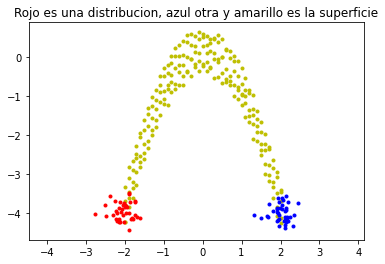

In [ ]:
puntos=40

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos+1)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos+1).reshape(-1,1)
W=np.concatenate((x,y),axis=1)


dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos+1)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos+1).reshape(-1,1) -0.5
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos+1)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos+1).reshape(-1,1) +0.5
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos+1)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos+1).reshape(-1,1) -0.25
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos+1)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos+1).reshape(-1,1) +0.25
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)




y1, y2 = np.random.multivariate_normal([2,-4], [[0.05,0],[0,0.05]], puntos).T
y1=np.array(y1)
y2=np.array(y2)
y1=y1.reshape(-1,1)
y2=y2.reshape(-1,1)

Ycol=np.concatenate((y1,y2),axis=1)
Y=Ycol.flatten()


x1, x2 = np.random.multivariate_normal([-2,-4], [[0.05,0],[0,0.05]], puntos).T
x1=np.array(x1)
x2=np.array(x2)
x1=x1.reshape(-1,1)
x2=x2.reshape(-1,1)
Zcol=np.concatenate((x1,x2),axis=1)
Z=Zcol.flatten()





plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.axis('equal')
plt.title('Rojo es una distribucion, azul otra y amarillo es la superficie')
plt.show()

In [ ]:
data=np.concatenate((Zcol,Ycol,W),axis=0)

samples=np.concatenate((Zcol,Ycol),axis=0) #los datos X iniciales, las distribuciones.
z=np.matrix([0 for i in range(Zcol.shape[0])]+[1 for i in range(Ycol.shape[0])]).T
#le pongo label 0 a la primera y 1 a la segunda

alpha=2
k=20
dimension=2
f_dist,tree=fermat_graph(data,alpha=alpha)

def my_fermat_cost(x,initialData):
    return fermat_cost_cuad_fast(x,initialData,dimension,f_dist,tree,data,k,alpha)

## llamo al baricentro con kernels de fermat

In [ ]:
def prueba_fermat(g,gg,q,qq):
    n_iter=300
    learningrate0=1
    landa0=g
    landamax=1e3
    beta_adapt=gg

    h=np.std(samples)*1.06*(samples.shape[0]**(-1/5))
    h=np.std(data)*1.06*(data.shape[0]**(-1/5))
    quantil=q
    quant2=qq
    factr=1
    h=-1 #Esto hace que el h se adapte a cada paso (con la formula de arriba pero con los y actuales, no fijado con los y_iniciales)!
    #h=2

    #cost_function=euclidean_cost_fast
    cost_function=my_fermat_cost
    #cost_function=cero


    monotono=True
    clb=True
    yinit=samples
    #yinit=np.zeros(samples.shape)
    #yinit=np.zeros(samples.shape)+np.random.random(samples.shape)*0.00001
    
    return barycenter_fermat(yinit,n_iter,samples,landa0,landamax,learningrate0,z,h,beta_adapt,cost_function,f_dist,tree,data,k,alpha,landa_monotono=monotono,quant=quantil,quant2=quant2,factor=factr,categorical=True,callback=clb)

In [ ]:
def plot_fermat(y,g,gg,q):
     #if cost_function==my_fermat_cost:
        plt.plot(W[:,0],W[:,1],'.',c='y')
        #plt.plot(x1,x2,'.',c='r')
        #plt.plot(y1,y2,'.',c='b')
        plt.plot(y[:puntos,0],y[:puntos,1],'x',c='r')
        plt.plot(y[puntos:,0],y[puntos:,1],'x',c='b')
        plt.title("landa0="+str(g)+", beta_adapt="+str(gg)+", quant="+str(q))
        plt.axis('equal')
        plt.show()

it: 0, paso: 5.1421224033268e-08, landa: 0.01, h:1.638577821175874
it: 1, paso: 3.856591735164111e-08, landa: 0.015, h:1.6333210637031805
it: 2, paso: 5.804283973047666e-08, landa: 0.0225, h:1.6287001950223752
it: 3, paso: 0.733369596713636, landa: 0.03375, h:1.60816416367242
it: 4, paso: 0.6378674606158182, landa: 0.03375, h:1.5834010317856526
it: 5, paso: 0.5454308741218076, landa: 0.03375, h:1.5680297353910173
it: 6, paso: 0.45555523828444655, landa: 0.03375, h:1.5583003928092738
it: 7, paso: 0.39131462541663736, landa: 0.03375, h:1.552697384631593
it: 8, paso: 0.3354322261944848, landa: 0.03375, h:1.546823814736721
it: 9, paso: 0.2977352047310897, landa: 0.03375, h:1.5425220628279954
it: 10, paso: 0.07430504679828165, landa: 0.03375, h:1.54095618062861
it: 11, paso: 3.828995276604107e-15, landa: 0.03375, h:1.54095618062861
it: 12, paso: 1.0644741024051653e-15, landa: 0.050625, h:1.5362368844796697
it: 13, paso: 1.1623576372262285, landa: 0.0759375, h:1.509783465865024
it: 14, paso:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 49, paso: 1.4756568260463583e-14, landa: 6.568408355712892, h:0.2635658759903672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


it: 50, paso: 2.306461057785785e-14, landa: 9.852612533569339, h:0.26010468907235557


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 51, paso: 4.4284424619721524e-15, landa: 14.778918800354008, h:0.2581263576767865


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 52, paso: 5.38245826985004e-14, landa: 22.168378200531013, h:0.24741618918989156


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 53, paso: 4.134890434140905e-14, landa: 33.25256730079652, h:0.2428314224109076


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 54, paso: 1.9956304410427313e-15, landa: 49.87885095119478, h:0.2420490482011341


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 55, paso: 9.686381913384481e-14, landa: 74.81827642679217, h:0.24035128108123327


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 56, paso: 3.6498189193750644e-14, landa: 112.22741464018824, h:0.22456805445301453


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 57, paso: 1.7573513044031766e-15, landa: 168.34112196028235, h:0.21682583059919222


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 58, paso: 1.101225578786393e-14, landa: 252.51168294042353, h:0.2153374867719713


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 59, paso: 1.6842821990916662e-14, landa: 378.7675244106353, h:0.2114753828875751


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 60, paso: 5.0927542392450145e-14, landa: 568.1512866159529, h:0.21027148288372863


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 61, paso: 4.824858396830783e-15, landa: 852.2269299239294, h:0.20988600326126214


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 62, paso: 5.809232913348782e-14, landa: 1278.340394885894, h:0.20890183748165658


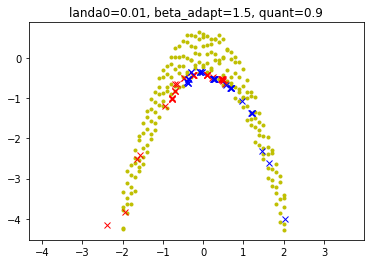

In [ ]:
g=0.01
gg=1.5
q=0.9
qq=0.51
plot_fermat(prueba_fermat(g,gg,q,qq),g,gg,q)

# Ej: Herradura

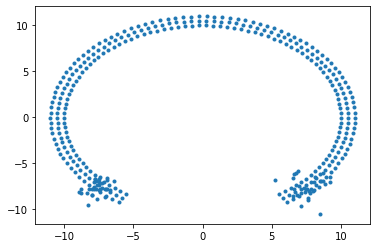

In [ ]:
densidad=300
puntos1=30
data2=np.zeros((densidad,2))
j=0
for tita in np.linspace(-np.pi/4-0.2,5*np.pi/4+0.2,densidad//3):
    for i in range(3):
        data2[j,:]=np.array([np.cos(tita),np.sin(tita)])*(10+i/2)
        j=j+1
        

samples2=np.zeros((60,2))        
samples2[:30,:]=np.random.multivariate_normal([-7.5,-7.5], [[0.5,0],[0,.5]], puntos1)      
samples2[30:,:]=np.random.multivariate_normal([7.5,-7.5], [[1,0],[0,1]], 30)
        
data2=np.concatenate((data2,samples2),axis=0)        

plt.plot(data2[:,0],data2[:,1],'.')
plt.show()

In [ ]:
z2=np.matrix([0 for i in range(30)]+[1 for i in range(30)]).T
#le pongo label 0 a la primera y 1 a la segunda

alpha2=2
k2=15
dimension2=2
f_dist2,tree2=fermat_graph(data2,alpha=alpha2)

def my_fermat_cost2(x,initialData):
    return fermat_cost_cuad_fast(x,initialData,dimension2,f_dist2,tree2,data2,k2,alpha2)

In [ ]:
def prueba2(g,gg):
    n_iter=300
    learningrate0=1
    landamax=1e6
    
    
    landa0=g
    beta_adapt=gg


    h=np.std(samples2)*1.06*(samples2.shape[0]**(-1/5))
    h=-1 #Esto hace que el h se adapte a cada paso (con la formula de arriba pero con los y actuales, no fijado con los y_iniciales)!
    #h=g
    
    h=-1
    quantil2=0.95
    factr2=1
    quant2=0.6

    #cost_function=euclidean_cost_fast
    
    cost_function=my_fermat_cost2
    #cost_function=cero

    yinit=samples2
    #yinit=np.zeros(samples.shape)+np.random.random(samples.shape)*0.00001
    
    monoton=True
    clb=True
    
    return barycenter_fermat(yinit,n_iter,samples2,landa0,landamax,learningrate0,z2,h,beta_adapt,cost_function,f_dist2,tree2,data2,k2,alpha2,landa_monotono=monoton,factor=factr2,quant=quantil2,quant2=quant2,categorical=True,callback=clb)

In [ ]:
def plot2(bari2,g,gg):
    #if cost_function==my_fermat_cost2:
    plt.plot(data2[:densidad,0],data2[:densidad,1],'.',c='y')
    plt.plot(data2[densidad:densidad+puntos1,0],data2[densidad:densidad+puntos1,1],'.',c='r')
    plt.plot(data2[densidad+puntos1:,0],data2[densidad+puntos1:,1],'.',c='b')
    plt.plot(bari2[:puntos1,0],bari2[:puntos1,1],'x',c='r')
    plt.plot(bari2[puntos1:,0],bari2[puntos1:,1],'x',c='b')
    plt.axis('equal')
    plt.title('landa0: '+str(g)+", beta_adapt: "+str(gg))
    plt.show()

it: 0, paso: 12.634235841087662, landa: 50, h:24.104108990953527
it: 1, paso: 20.846448905078297, landa: 50, h:24.567856790129984
it: 2, paso: 18.427386396869668, landa: 50, h:22.574475172889134
it: 3, paso: 9.704223589536221, landa: 50, h:20.7547328806553
it: 4, paso: 12.793103764676797, landa: 50, h:19.305994686992626
it: 5, paso: 7.231638169970066, landa: 50, h:18.465174943610357
it: 6, paso: 14.126700562476412, landa: 50, h:17.134015557230416
it: 7, paso: 7.437745540626171, landa: 50, h:16.281021443059796
it: 8, paso: 7.486811338688019, landa: 50, h:15.534996100322399
it: 9, paso: 6.990598534506291, landa: 50, h:14.890201652257959
it: 10, paso: 7.525393276172455, landa: 50, h:14.22943950487238
it: 11, paso: 7.3013546432287395, landa: 50, h:13.447159988726957
it: 12, paso: 8.262221537777975, landa: 50, h:12.871347130976421
it: 13, paso: 8.90989154579127, landa: 50, h:12.387716472156812
it: 14, paso: 10.042206412313272, landa: 50, h:11.810063862183814
it: 15, paso: 6.114700138529679,

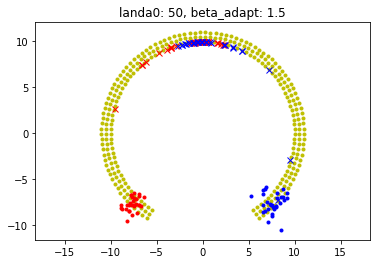

In [ ]:
g=50
gg=1.5
plot2(prueba2(g,gg),g,gg)

# Ej: herradura+ruido

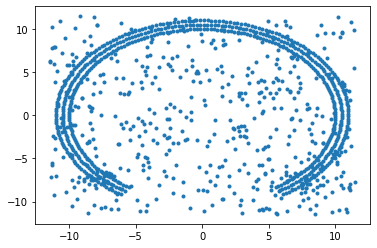

In [ ]:
densidad=600
puntos1=30
data3=np.zeros((densidad,2))
j=0
for tita in np.linspace(-np.pi/4-0.2,5*np.pi/4+0.2,densidad//3):
    for i in range(3):
        data3[j,:]=np.array([np.cos(tita),np.sin(tita)])*(10+i/2)
        j=j+1
        

samples3=np.zeros((60,2))        
samples3[:30,:]=np.random.multivariate_normal([-7.5,-7.5], [[0.5,0],[0,.5]], puntos1)      
samples3[30:,:]=np.random.multivariate_normal([7.5,-7.5], [[1,0],[0,1]], 30)
        
    

densidad2=500
data3=np.concatenate((data3,23*(np.random.random((densidad2,2))-0.5)),axis=0)
    
data3=np.concatenate((data3,samples3),axis=0)


#para el plot de dsps
densidad=densidad+densidad2

plt.plot(data3[:,0],data3[:,1],'.')
plt.show()

In [ ]:
z3=np.matrix([0 for i in range(30)]+[1 for i in range(30)]).T
#le pongo label 0 a la primera y 1 a la segunda

alpha3=2
k3=15
dimension3=2
f_dist3,tree3=fermat_graph(data3,alpha=alpha3)

def my_fermat_cost3(x,initialData):
    return fermat_cost_cuad_fast(x,initialData,dimension3,f_dist3,tree3,data3,k3,alpha3)

In [ ]:
def prueba3(g,gg):
    n_iter=300
    learningrate0=1
    landamax=1e5
    
    
    landa0=g
    beta_adapt=gg


    h=np.std(samples2)*1.06*(samples2.shape[0]**(-1/5))
    h=-1 #Esto hace que el h se adapte a cada paso (con la formula de arriba pero con los y actuales, no fijado con los y_iniciales)!
    #h=g
    
    h=-1
    quantil3=0.95
    quant2=0.7

    #cost_function=euclidean_cost_fast
    
    cost_function=my_fermat_cost3
    #cost_function=cero

    yinit=samples3
    #yinit=np.zeros(samples.shape)+np.random.random(samples.shape)*0.00001
    
    monoton=True
    clb=True
    
    return barycenter_fermat(yinit,n_iter,samples3,landa0,landamax,learningrate0,z3,h,beta_adapt,cost_function,f_dist3,tree3,data3,k3,alpha3,landa_monotono=monoton,quant=quantil3,quant2=quant2,categorical=True,callback=clb)

In [ ]:
def plot3(bari3,g,gg):
    #if cost_function==my_fermat_cost2:
    plt.plot(data3[:densidad,0],data3[:densidad,1],'.',c='y')
    plt.plot(data3[densidad:densidad+puntos1,0],data3[densidad:densidad+puntos1,1],'.',c='r')
    plt.plot(data3[densidad+puntos1:,0],data3[densidad+puntos1:,1],'.',c='b')
    plt.plot(bari3[:puntos1,0],bari3[:puntos1,1],'x',c='r')
    plt.plot(bari3[puntos1:,0],bari3[puntos1:,1],'x',c='b')
    plt.axis('equal')
    plt.title('landa0: '+str(g)+", beta_adapt: "+str(gg))
    plt.show()

it: 0, paso: 13.62053666091864, landa: 10, h:11.895684372832134
it: 1, paso: 12.947276843330789, landa: 10, h:11.851990670214917
it: 2, paso: 15.939748733831891, landa: 10, h:11.691728259693438
it: 3, paso: 9.483261055611628, landa: 10, h:10.435772487496079
it: 4, paso: 7.398371278666221, landa: 10, h:10.098487714920799
it: 5, paso: 15.3321687782671, landa: 10, h:9.752505113102714
it: 6, paso: 10.165485938988422, landa: 10, h:9.29797993846686
it: 7, paso: 9.189188016746579, landa: 10, h:8.811931499287805
it: 8, paso: 9.335859584664295, landa: 10, h:8.658268170509023
it: 9, paso: 10.847273047190866, landa: 10, h:8.362760344287354
it: 10, paso: 5.51416110759855, landa: 10, h:7.6465045954569995
it: 11, paso: 8.698321373892298, landa: 10, h:7.354780624898155
it: 12, paso: 10.183199145669192, landa: 10, h:6.905406579344736
it: 13, paso: 6.148169700692604, landa: 10, h:6.448494447890547
it: 14, paso: 10.536642318907413, landa: 10, h:6.091396633818275
it: 15, paso: 6.600147194798462, landa: 1

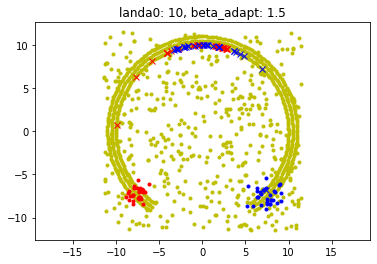

In [ ]:
g=10
gg=1.5
plot3(prueba3(g,gg),g,gg)

## Veamos si agregamos puntitos mas difusos en el medio del arco

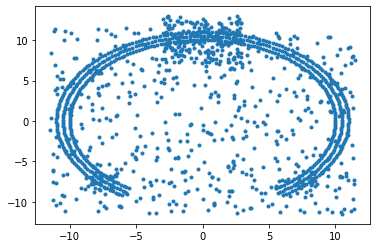

In [ ]:
densidad=600
puntos1=30
data3=np.zeros((densidad,2))
j=0
for tita in np.linspace(-np.pi/4-0.2,5*np.pi/4+0.2,densidad//3):
    for i in range(3):
        data3[j,:]=np.array([np.cos(tita),np.sin(tita)])*(10+i/2)
        j=j+1
        

samples3=np.zeros((60,2))        
samples3[:30,:]=np.random.multivariate_normal([-7.5,-7.5], [[0.5,0],[0,.5]], puntos1)      
samples3[30:,:]=np.random.multivariate_normal([7.5,-7.5], [[1,0],[0,1]], 30)
        
    

densidad2=500
densidad3=200
data3=np.concatenate((data3,23*(np.random.random((densidad2,2))-0.5)),axis=0)
data3=np.concatenate((data3,(6*np.random.random((densidad3,2))+[-3,7.])),axis=0)
    
data3=np.concatenate((data3,samples3),axis=0)


#para el plot de dsps
densidad=densidad+densidad2+densidad3

plt.plot(data3[:,0],data3[:,1],'.')
plt.show()

In [ ]:
z3=np.matrix([0 for i in range(30)]+[1 for i in range(30)]).T
#le pongo label 0 a la primera y 1 a la segunda

alpha3=2
k3=15
dimension3=2
f_dist3,tree3=fermat_graph(data3,alpha=alpha3)

def my_fermat_cost3(x,initialData):
    return fermat_cost_cuad_fast(x,initialData,dimension3,f_dist3,tree3,data3,k3,alpha3)

In [ ]:
def prueba3(g,gg):
    n_iter=300
    learningrate0=1
    landamax=1e5
    
    
    landa0=g
    beta_adapt=gg


    h=np.std(samples2)*1.06*(samples2.shape[0]**(-1/5))
    h=-1 #Esto hace que el h se adapte a cada paso (con la formula de arriba pero con los y actuales, no fijado con los y_iniciales)!
    #h=g
    
    h=-1
    quantil3=0.95
    quant2=0.7

    #cost_function=euclidean_cost_fast
    
    cost_function=my_fermat_cost3
    #cost_function=cero

    yinit=samples3
    #yinit=np.zeros(samples.shape)+np.random.random(samples.shape)*0.00001
    
    monoton=True
    clb=True
    
    return barycenter_fermat(yinit,n_iter,samples3,landa0,landamax,learningrate0,z3,h,beta_adapt,cost_function,f_dist3,tree3,data3,k3,alpha3,landa_monotono=monoton,quant=quantil3,quant2=quant2,categorical=True,callback=clb)

it: 0, paso: 14.163283250901282, landa: 10, h:12.330208417721789
it: 1, paso: 15.516660656727929, landa: 10, h:12.437769157387113
it: 2, paso: 18.933864375294014, landa: 10, h:12.287572352611605
it: 3, paso: 11.540948058034438, landa: 10, h:11.136744727475339
it: 4, paso: 8.193958559362994, landa: 10, h:10.720200080045226
it: 5, paso: 15.119048902940648, landa: 10, h:10.796882662525805
it: 6, paso: 8.772191869801041, landa: 10, h:9.742880178898211
it: 7, paso: 7.85766346620194, landa: 10, h:9.529656907682446
it: 8, paso: 7.349815457139302, landa: 10, h:9.133637507981222
it: 9, paso: 8.46225196623948, landa: 10, h:8.756402221493374
it: 10, paso: 4.550024168619821, landa: 10, h:8.446991921188072
it: 11, paso: 8.109289050751501, landa: 10, h:7.970891896365738
it: 12, paso: 9.24248187903537, landa: 10, h:8.315081429001006
it: 13, paso: 9.28930186750266, landa: 10, h:7.34116074569085
it: 14, paso: 5.0012807989105, landa: 10, h:7.087110257976004
it: 15, paso: 8.442654697333642, landa: 10, h:

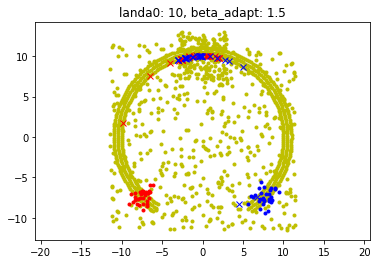

In [ ]:
g=10
gg=1.5
plot3(prueba3(g,gg),g,gg)

Es delicado el landamax tambien, para que no se desvirtue el baricentro. QUizas una vez que termino con landa, podria correr unas iteraciones mas para mejorar el costo con ese landa final fijo?

# Ej: swiss roll

In [ ]:
def generate_swiss_roll(oscilations, A, n):

    mean1 = [0.3,0.3]
    mean2 = [0.3,0.7]
    mean3 = [0.7,0.3]
    mean4 = [0.7,0.7]
    mean5= [1,0.3]
    cov   = [[0.01,0],[0,0.01]]

    X1 = np.random.multivariate_normal(mean1, cov, n)
    X3 = np.random.multivariate_normal(mean3, cov, n)
    X5 = np.random.multivariate_normal(mean5, cov, n)
    XX = np.concatenate((X1,X3,X5), axis=0)

    labels = [0]*n + [1]*n+ [2]*n 

    X = np.zeros((XX.shape[0],3))
    for i in range(X.shape[0]):
        x, y = XX[i,0], XX[i,1]
        X[i,0] = x * np.cos( oscilations * x ) 
        X[i,1] = A*y
        X[i,2] = x * np.sin( oscilations * x ) 
        
    return X,labels

In [ ]:
n_data = 1000
n_samples=100
data, labels = generate_swiss_roll(oscilations = 3, A = 10, n = n_data//3)
samples=data[:n_samples//2]
samples=np.concatenate((samples,data[-n_samples//2:]),axis=0)

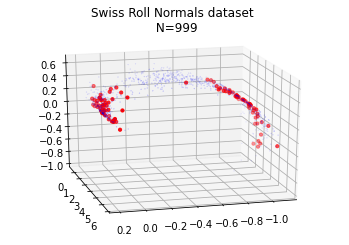

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, 75)
ax.scatter(xs=data[:,0], ys=data[:,1], zs=data[:,2],c='b', s=0.01)
ax.scatter(xs=samples[:,0], ys=samples[:,1], zs=samples[:,2], s=10,c='r')
plt.title('Swiss Roll Normals dataset \n N=%s'%(data.shape[0]))

plt.show()

In [ ]:
z2=np.matrix([0 for i in range(n_samples//2)]+[1 for i in range(n_samples//2)]).T
#le pongo label 0 a la primera y 1 a la segunda

alpha2=2
k2=30
dimension2=3
f_dist2,tree2=fermat_graph(data,alpha=alpha2)

def my_fermat_cost2(x,initialData):
    return fermat_cost_cuad_fast(x,initialData,dimension2,f_dist2,tree2,data,k2,alpha2)

In [ ]:
def prueba2(g,gg,q,qq,h):
    n_iter=300
    learningrate0=1
    landamax=100
    
    
    landa0=g
    beta_adapt=gg

    
    h=h
    quantil2=q
    q2=qq
    fctr=1

    #cost_function=euclidean_cost_fast
    cost_function=my_fermat_cost2
    #cost_function=cero

    yinit=samples
    #yinit=np.zeros(samples.shape)+np.random.random(samples.shape)*0.00001
    
    monoton=True
    clb=True
    #clb=False
    
    return barycenter_fermat(yinit,n_iter,samples,landa0,landamax,learningrate0,z2,h,beta_adapt,cost_function,f_dist2,tree2,data,k2,alpha2,quant2=q2,landa_monotono=monoton,factor=fctr,quant=quantil2,categorical=True,callback=clb)

In [ ]:
def plot2(bari2,g,gg,q,qq,h):
  fig = plt.figure()

  ax = fig.add_subplot(111, projection='3d')
  ax.view_init(20, 75)
  ax.scatter(xs=data[:,0], ys=data[:,1], zs=data[:,2],c='b', s=0.01)
  ax.scatter(xs=samples[:,0], ys=samples[:,1], zs=samples[:,2],c='r', s=1)
  ax.scatter(xs=bari2[:n_samples//2,0], ys=bari2[:n_samples//2,1], zs=bari2[:n_samples//2,2], s=10,c='g')
  ax.scatter(xs=bari2[n_samples//2:,0], ys=bari2[n_samples//2:,1], zs=bari2[n_samples//2:,2], s=10,c='y')

  plt.title('landa0:'+str(g)+", bbeta_adapt:"+str(gg)+", quant:"+str(q)+",quant2:"+str(qq)+", h:"+str(h))

  plt.show()

it: 0, paso: 3.97212922154028e-08, landa: 0.01, h:0.3004854355820768
it: 1, paso: 1.4895484470730528e-08, landa: 0.015, h:0.30048543555888463
it: 2, paso: 1.1171613322634037e-08, landa: 0.0225, h:0.30048543554149054
it: 3, paso: 1.675741994943372e-08, landa: 0.03375, h:0.30048543551539947
it: 4, paso: 0.42171427983285636, landa: 0.050625, h:0.30018642686847086
it: 5, paso: 3.0282175687274555e-15, landa: 0.050625, h:0.30018642686847086
it: 6, paso: 5.652386285573981e-16, landa: 0.0759375, h:0.30018642686847086
it: 7, paso: 2.1200281666808729e-16, landa: 0.11390625000000001, h:0.30018642686847086
it: 8, paso: 7.951064046039932e-17, landa: 0.17085937500000004, h:0.30018642686847086
it: 9, paso: 5.963777294007934e-17, landa: 0.25628906250000005, h:0.30018642686847086
it: 10, paso: 8.946145233138018e-17, landa: 0.3844335937500001, h:0.30018642686847086
it: 11, paso: 6.709848581797438e-17, landa: 0.5766503906250001, h:0.30018642686847086
it: 12, paso: 5.0325062684465815e-17, landa: 0.8649755

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 14, paso: 5.661719345953225e-17, landa: 1.9461950683593754, h:0.30018642686847086


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 15, paso: 8.492638937530828e-17, landa: 2.919292602539063, h:0.30018642686847086


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 16, paso: 6.369509162627669e-17, landa: 4.378938903808595, h:0.30018642686847086


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 17, paso: 9.554293703540421e-17, landa: 6.568408355712892, h:0.30018642686847086


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 18, paso: 7.165735257494565e-17, landa: 9.852612533569339, h:0.30018642686847086


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 19, paso: 5.374308933053811e-17, landa: 14.778918800354008, h:0.30018642686847086


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 20, paso: 8.061470889522447e-17, landa: 22.168378200531013, h:0.30018642686847086


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 21, paso: 6.046106912115647e-17, landa: 33.25256730079652, h:0.30018642686847086


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 22, paso: 9.069164113149246e-17, landa: 49.87885095119478, h:0.30018642686847086


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 23, paso: 6.801874957350479e-17, landa: 74.81827642679217, h:0.30018642686847086


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 24, paso: 5.101407154257349e-17, landa: 112.22741464018824, h:0.30018642686847086


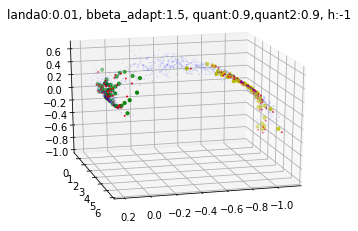

it: 0, paso: 1.8853883390615052, landa: 0.01, h:0.23137362654743485
it: 1, paso: 1.380092754790228, landa: 0.01, h:0.22732988588857891
it: 2, paso: 1.1918894810432525, landa: 0.01, h:0.21986546011704916
it: 3, paso: 0.8609209850945868, landa: 0.01, h:0.21759738447534638
it: 4, paso: 0.6355045278723515, landa: 0.01, h:0.2145780087226325
it: 5, paso: 0.5509339644716283, landa: 0.01, h:0.21430153969094246
it: 6, paso: 0.1179993904899193, landa: 0.01, h:0.21424162822881312
it: 7, paso: 0.1027362100672585, landa: 0.01, h:0.21394735223835706
it: 8, paso: 2.6652721516232943e-15, landa: 0.01, h:0.21394735223835706
it: 9, paso: 3.11413093663343e-16, landa: 0.015, h:0.21394735223835706
it: 10, paso: 1.4484250290651037e-16, landa: 0.0225, h:0.21394735223835706
it: 11, paso: 9.976654416329114e-16, landa: 0.03375, h:0.21394735223835706
it: 12, paso: 0.4593739528438564, landa: 0.050625, h:0.21217427803423267
it: 13, paso: 1.0736124500608167e-15, landa: 0.050625, h:0.21217427803423267
it: 14, paso: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 29, paso: 3.5115145758832715e-17, landa: 14.778918800354008, h:0.19859698589533065


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 30, paso: 2.6349890682395477e-17, landa: 22.168378200531013, h:0.19859698589533065


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 31, paso: 3.9538402978162505e-17, landa: 33.25256730079652, h:0.19859698589533065


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 32, paso: 2.966059756179017e-17, landa: 49.87885095119478, h:0.19859698589533065


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 33, paso: 4.44976995657134e-17, landa: 74.81827642679217, h:0.19859698589533065


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 34, paso: 3.3376678916145335e-17, landa: 112.22741464018824, h:0.19859698589533065


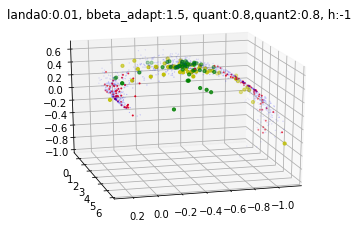

it: 0, paso: 1.3328253985938625, landa: 0.01, h:0.3184392723252126
it: 1, paso: 4.114433936389107e-16, landa: 0.01, h:0.3184392723252126
it: 2, paso: 6.360359353536008e-16, landa: 0.015, h:0.3128125661989463
it: 3, paso: 1.1325756123842214, landa: 0.0225, h:0.32610460428813953
it: 4, paso: 2.0445713186895267, landa: 0.0225, h:0.2892751009700791
it: 5, paso: 1.5635844920950333, landa: 0.0225, h:0.28667041540051863
it: 6, paso: 1.1319244746076467, landa: 0.0225, h:0.291449385205268
it: 7, paso: 0.9421054494001809, landa: 0.0225, h:0.2958339682082956
it: 8, paso: 1.0174874881090124e-15, landa: 0.0225, h:0.29583396820829555
it: 9, paso: 1.9842115837175174e-16, landa: 0.03375, h:0.28982106220213755
it: 10, paso: 0.8118794378379843, landa: 0.050625, h:0.2778720161126061
it: 11, paso: 2.8243732944438603e-16, landa: 0.050625, h:0.27787201611260615
it: 12, paso: 4.2229284611859883e-16, landa: 0.0759375, h:0.2721076419714231
it: 13, paso: 1.7188624350688658e-16, landa: 0.11390625000000001, h:0.2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 29, paso: 2.805975292473145e-10, landa: 14.778918800354008, h:0.20716690749176825


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 30, paso: 2.1400403725578193e-10, landa: 22.168378200531013, h:0.20521019931538753


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 31, paso: 3.2682728607226647e-10, landa: 33.25256730079652, h:0.20390905951264104


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 32, paso: 2.4832417305464053e-10, landa: 49.87885095119478, h:0.20247591340576693


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 33, paso: 1.8872926463753167e-10, landa: 74.81827642679217, h:0.20084739243104813


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 34, paso: 2.873942641439829e-10, landa: 112.22741464018824, h:0.19943750548655598


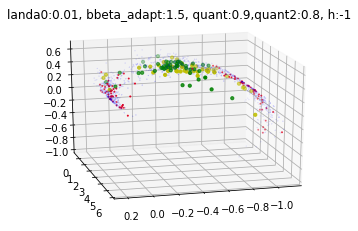

it: 0, paso: 0.9973418768532075, landa: 0.01, h:0.36439606815889747
it: 1, paso: 0.41927940237449607, landa: 0.01, h:0.3747785179325657
it: 2, paso: 5.886389092880073e-16, landa: 0.01, h:0.37477851793256567
it: 3, paso: 2.3862667574867515e-16, landa: 0.015, h:0.364462152888981
it: 4, paso: 0.4461356873881785, landa: 0.0225, h:0.3611663193733401
it: 5, paso: 0.8471664563341275, landa: 0.0225, h:0.36449259444320575
it: 6, paso: 1.541607139414856, landa: 0.0225, h:0.33736753280375154
it: 7, paso: 1.8227526109006351, landa: 0.0225, h:0.3073151926962959
it: 8, paso: 0.6864726780688891, landa: 0.0225, h:0.31705393245552216
it: 9, paso: 1.0877191409535845, landa: 0.0225, h:0.3325255168868028
it: 10, paso: 0.6432970765192688, landa: 0.0225, h:0.34183890091185193
it: 11, paso: 0.15962660358278996, landa: 0.0225, h:0.330850443909525
it: 12, paso: 0.03710978518882214, landa: 0.0225, h:0.3314741533445384
it: 13, paso: 1.9999833931137582e-15, landa: 0.0225, h:0.3314741533445384
it: 14, paso: 4.0684

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 36, paso: 4.128229546678002e-16, landa: 49.87885095119478, h:0.20864266713195034


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 37, paso: 3.1459373521947286e-16, landa: 74.81827642679217, h:0.205310776153165


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 38, paso: 4.831883483208595e-16, landa: 112.22741464018824, h:0.203162293692782


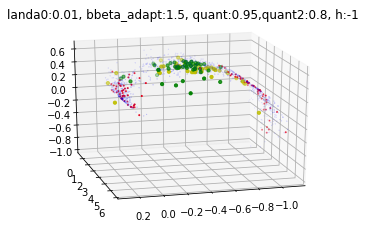

it: 0, paso: 2.7701759919079487, landa: 0.01, h:0.16102610854329358
it: 1, paso: 2.3064496376536803, landa: 0.01, h:0.1417083833449872
it: 2, paso: 1.678302682767243, landa: 0.01, h:0.1320665456267855
it: 3, paso: 1.023779445679889, landa: 0.01, h:0.1271736961210289
it: 4, paso: 0.5662484740750074, landa: 0.01, h:0.1262292304410254
it: 5, paso: 0.3631286014593774, landa: 0.01, h:0.12523145031914312
it: 6, paso: 3.801721164518651e-10, landa: 0.01, h:0.12523145032148017
it: 7, paso: 1.191643546732344e-15, landa: 0.015, h:0.12462075103257478
it: 8, paso: 1.0530637913748058e-15, landa: 0.0225, h:0.12402232850777939
it: 9, paso: 7.156064902322351e-15, landa: 0.03375, h:0.12333229953714837
it: 10, paso: 4.6702798276630346e-14, landa: 0.050625, h:0.12248866277404258
it: 11, paso: 1.854632428726081e-14, landa: 0.0759375, h:0.12181743853988239
it: 12, paso: 4.739650271448153e-10, landa: 0.11390625000000001, h:0.12128123129390606
it: 13, paso: 3.6495875829946473e-10, landa: 0.17085937500000004, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 22, paso: 4.68435780131039e-10, landa: 6.568408355712892, h:0.11793850535400588


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 23, paso: 3.520740835931158e-10, landa: 9.852612533569339, h:0.11750976134773733


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 24, paso: 5.29714547459696e-10, landa: 14.778918800354008, h:0.11719039067952022


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 25, paso: 3.985285454181727e-10, landa: 22.168378200531013, h:0.11684994894449952


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 26, paso: 2.997326513564521e-10, landa: 33.25256730079652, h:0.11649612481841846


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 27, paso: 4.5091398417328526e-10, landa: 49.87885095119478, h:0.11638357334045024


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 28, paso: 3.388142266853749e-10, landa: 74.81827642679217, h:0.11622030254078246


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 29, paso: 5.088301509030368e-10, landa: 112.22741464018824, h:0.11600236221236157


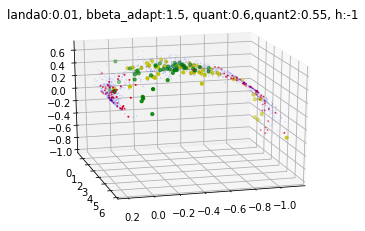

it: 0, paso: 1.8853883390615052, landa: 0.01, h:0.23137362654743485
it: 1, paso: 1.380092754790228, landa: 0.01, h:0.22732988588857891
it: 2, paso: 1.1918894810432525, landa: 0.01, h:0.21986546011704916
it: 3, paso: 0.8609209850945868, landa: 0.01, h:0.21759738447534638
it: 4, paso: 0.6355045278723515, landa: 0.01, h:0.2145780087226325
it: 5, paso: 0.2754669822358142, landa: 0.01, h:0.21406267822020505
it: 6, paso: 6.9980717880760434e-15, landa: 0.01, h:0.21406267822020497
it: 7, paso: 1.5190714233902078e-15, landa: 0.015, h:0.20847057428297333
it: 8, paso: 1.711389905700933e-16, landa: 0.0225, h:0.20311115488194253
it: 9, paso: 0.6626089369399796, landa: 0.03375, h:0.19811171436614283
it: 10, paso: 0.9328981039124042, landa: 0.03375, h:0.19401393091294417
it: 11, paso: 1.4075084326498355, landa: 0.03375, h:0.19175757798277726
it: 12, paso: 3.914016388001805e-16, landa: 0.03375, h:0.19175757798277726
it: 13, paso: 1.2781759797071724e-15, landa: 0.050625, h:0.1876228533336474
it: 14, pa

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 26, paso: 1.1466575535812988e-16, landa: 6.568408355712892, h:0.16348614983652127


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 27, paso: 8.668499036681894e-17, landa: 9.852612533569339, h:0.16213610483462115


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 28, paso: 3.277014306064727e-17, landa: 14.778918800354008, h:0.16065301734161533


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 29, paso: 2.4814784711596192e-17, landa: 22.168378200531013, h:0.15973214319655488


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 30, paso: 3.749683333349014e-17, landa: 33.25256730079652, h:0.1584579297313189


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 31, paso: 2.834764086216372e-17, landa: 49.87885095119478, h:0.15706282628800666


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 32, paso: 2.1461587276891128e-17, landa: 74.81827642679217, h:0.1561583382140765


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 33, paso: 1.6215576276121147e-17, landa: 112.22741464018824, h:0.15571393904375638


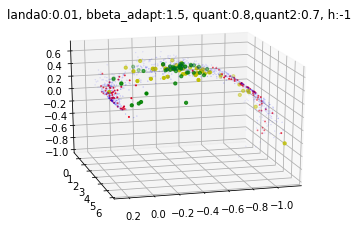

it: 0, paso: 0.9973418768532075, landa: 0.01, h:0.36439606815889747
it: 1, paso: 0.41927940237449607, landa: 0.01, h:0.3747785179325657
it: 2, paso: 5.886389092880073e-16, landa: 0.01, h:0.37477851793256567
it: 3, paso: 2.3862667574867515e-16, landa: 0.015, h:0.35851699617369664
it: 4, paso: 0.45706024687416674, landa: 0.0225, h:0.35057053044648073
it: 5, paso: 0.8831728569985119, landa: 0.0225, h:0.354569567779517
it: 6, paso: 0.7988630513888422, landa: 0.0225, h:0.33609207939060576
it: 7, paso: 1.4791512571050913, landa: 0.0225, h:0.3239485781090158
it: 8, paso: 0.28153558226792114, landa: 0.0225, h:0.3156603553066782
it: 9, paso: 0.5516495318871326, landa: 0.0225, h:0.31414586816119594
it: 10, paso: 0.9851195531383139, landa: 0.0225, h:0.338139592718929
it: 11, paso: 0.4567032366715681, landa: 0.0225, h:0.3449484658928798
it: 12, paso: 2.149728296693675e-15, landa: 0.0225, h:0.34494846589287975
it: 13, paso: 2.37429850245232e-16, landa: 0.03375, h:0.3274989675632798
it: 14, paso: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 32, paso: 2.545166702108659e-10, landa: 9.852612533569339, h:0.18296144014236737


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 33, paso: 1.9786583268263616e-10, landa: 14.778918800354008, h:0.17985840401998054


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 34, paso: 3.0585355193706507e-10, landa: 22.168378200531013, h:0.17590081530356727


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 35, paso: 2.3789458016490773e-10, landa: 33.25256730079652, h:0.1726063135448455


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 36, paso: 1.8451976611274276e-10, landa: 49.87885095119478, h:0.17005076416514325


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 37, paso: 2.844347010317847e-10, landa: 74.81827642679217, h:0.16829955054795362


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 38, paso: 2.175636085898578e-10, landa: 112.22741464018824, h:0.16695228638438492


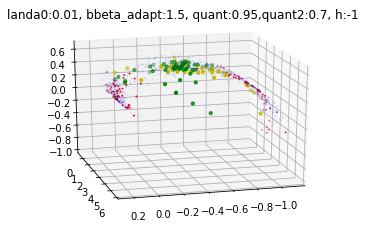

it: 0, paso: 2.7701759919079487, landa: 0.01, h:0.16102610854329358
it: 1, paso: 2.3064496376536803, landa: 0.01, h:0.1417083833449872
it: 2, paso: 1.678302682767243, landa: 0.01, h:0.1320665456267855
it: 3, paso: 1.023779445679889, landa: 0.01, h:0.1271736961210289
it: 4, paso: 0.5662484740750074, landa: 0.01, h:0.1262292304410254
it: 5, paso: 0.3631286014593774, landa: 0.01, h:0.12523145031914312
it: 6, paso: 5.800966132383195e-15, landa: 0.01, h:0.12523145031914312
it: 7, paso: 0.3354178396595721, landa: 0.015, h:0.12491929057556383
it: 8, paso: 5.41226604093227e-17, landa: 0.015, h:0.12491929057556383
it: 9, paso: 3.13763431698206e-15, landa: 0.0225, h:0.12491929057556383
it: 10, paso: 2.764851212305678e-15, landa: 0.03375, h:0.12491929057556383
it: 11, paso: 2.3082889423986918e-15, landa: 0.050625, h:0.12491929057556383
it: 12, paso: 2.3191605976575766e-16, landa: 0.0759375, h:0.12491929057556383
it: 13, paso: 3.638401210853107e-16, landa: 0.11390625000000001, h:0.1249192905755638

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 26, paso: 3.014236622644931e-16, landa: 22.168378200531013, h:0.12491929057556383


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 27, paso: 5.652507503385264e-17, landa: 33.25256730079652, h:0.12491929057556383


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 28, paso: 2.1198937810439195e-17, landa: 49.87885095119478, h:0.12491929057556383


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 29, paso: 1.2720176577469092e-16, landa: 74.81827642679217, h:0.12491929057556383


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 30, paso: 4.77026969303619e-17, landa: 112.22741464018824, h:0.12491929057556383


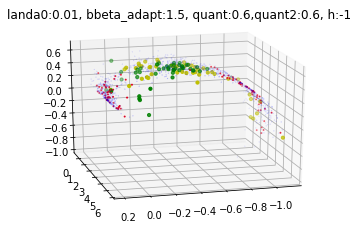

In [ ]:
g=0.01
gg=1.5
h=-1
for q,qq in [(0.9,0.9),(0.8,0.8),(0.9,0.8),(0.95,0.8),(0.6,0.55),(0.8,0.7),(0.95,0.7),(0.6,0.6)]:
  plot2(prueba2(g,gg,q,qq,h),g,gg,q,qq,h)

# Ejemplo en dimension más alta

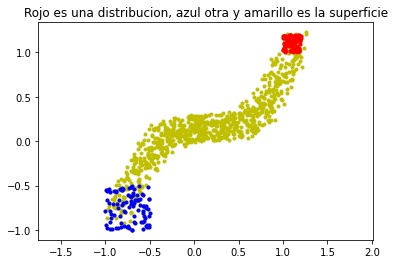

In [ ]:
n=400
eps=0.3
eps2=0.01
dim_extra=18#CUANDO SUBO LA DIMENSION TENGO QUE AUMENTAR MUCHO EL LEARNING RATE, ESO POR QUE ES?
#creo que es que los kernels se hacen tremendamente chicos, habria que normalizar por la dimension de la variedad en la que trabajo, lo que ni idea
#mas facil volar esa normalizacion como volumen del abola d dimensional y ya

data1=np.array([np.linspace(-1,1,n),np.linspace(-1,1,n)**3]).T+np.random.random((n,2))*eps
data2=np.array([np.linspace(-1,1,n),np.linspace(-1,1,n)**3]).T+np.random.random((n,2))*eps
data=np.concatenate((data1,data2),axis=0)
data=np.concatenate((data,eps2*np.random.random((data.shape[0],dim_extra))),axis=1)

n_samples=100

samples1=0.5*np.random.random((n_samples,2))-[1,1]
samples2=0.2*np.random.random((n_samples,2))+[1,1]
samples=np.concatenate((samples1,samples2),axis=0)
samples=np.concatenate((samples,eps2*np.random.random((samples.shape[0],dim_extra))),axis=1)   #CON RUIDO LA SUPERFICIE
#samples=np.concatenate((samples,np.zeros((samples.shape[0],dim_extra))),axis=1)      #SIN RUIDO  EN+ DIM LA SUPERFICIE

data=np.concatenate((data,samples),axis=0)

plt.plot(data[:,0],data[:,1],'.',c='y')
plt.plot(samples[n_samples:,0],samples[n_samples:,1],'.',c='r')
plt.plot(samples[:n_samples,0],samples[:n_samples,1],'.',c='b')
plt.axis('equal')
plt.title('Rojo es una distribucion, azul otra y amarillo es la superficie')
plt.show()

In [ ]:
z2=np.matrix([0 for i in range(n_samples)]+[1 for i in range(n_samples)]).T
#le pongo label 0 a la primera y 1 a la segunda

alpha2=2
k2=20
dimension2=2+dim_extra
f_dist2,tree2=fermat_graph(data,alpha=alpha2)

def my_fermat_cost2(x,initialData):
    return fermat_cost_cuad_fast(x,initialData,dimension2,f_dist2,tree2,data,k2,alpha2)

In [ ]:
def prueba2(g,gg,q,qq,h):
    n_iter=100
    learningrate0=1
    landamax=1e3
    
    
    landa0=g
    beta_adapt=gg

    
    h=h
    quantil2=q
    q2=qq
    fctr=1
    #cost_function=euclidean_cost_fast
    def cero(a,b):
      return 0, np.zeros(a.shape)
    cost_function=my_fermat_cost2
    #cost_function=cero

    yinit=samples
    #yinit=np.zeros(samples.shape)+np.random.random(samples.shape)*0.00001
    
    monoton=True
    clb=True
    #clb=False
    
    return barycenter_fermat(yinit,n_iter,samples,landa0,landamax,learningrate0,z2,h,beta_adapt,cost_function,f_dist2,tree2,data,k2,alpha2,landa_monotono=monoton,factor=fctr,quant=quantil2,quant2=q2,categorical=True,callback=clb)

In [ ]:
def plot2(bari2,g,gg,q,qq,h):
  plt.plot(data[:,0],data[:,1],'.',c='y')
  plt.plot(samples[n_samples:,0],samples[n_samples:,1],'.',c='r')
  plt.plot(samples[:n_samples,0],samples[:n_samples,1],'.',c='b')
  plt.plot(bari2[:n_samples,0],bari2[:n_samples,1],'x',c='b')
  plt.plot(bari2[n_samples:,0],bari2[n_samples:,1],'x',c='r')
  plt.axis('equal')
  plt.title('Rojo es una distribucion, azul otra y amarillo es la superficie')
  plt.title('landa0:'+str(g)+", bbeta_adapt:"+str(gg)+", quant:"+str(q)+", quant2:"+str(qq)+", h:"+str(h))
  plt.show()

it: 0, paso: 4.004475480445657e-08, landa: 0.001, h:0.15853696712836676
it: 1, paso: 1.501678261877431e-08, landa: 0.0015, h:0.15380926878675186
it: 2, paso: 0.39148185237540567, landa: 0.0022500000000000003, h:0.15002616815074662
it: 3, paso: 0.36430096448888566, landa: 0.0022500000000000003, h:0.14556577789340314
it: 4, paso: 0.3466009961288533, landa: 0.0022500000000000003, h:0.1426017325662431
it: 5, paso: 0.33534061869713494, landa: 0.0022500000000000003, h:0.1396194373624468
it: 6, paso: 0.3468255121533749, landa: 0.0022500000000000003, h:0.13749294240371548
it: 7, paso: 0.35697103846542766, landa: 0.0022500000000000003, h:0.135760302116318
it: 8, paso: 0.3494825291852698, landa: 0.0022500000000000003, h:0.13352599573135931
it: 9, paso: 0.3647976689027174, landa: 0.0022500000000000003, h:0.131393468712499
it: 10, paso: 0.36229486071752204, landa: 0.0022500000000000003, h:0.12994267463879994
it: 11, paso: 0.3590558044925262, landa: 0.0022500000000000003, h:0.1282277010891403
it: 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 73, paso: 3.8973776005703064e-17, landa: 1.4778918800354004, h:0.016310066257330044


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 74, paso: 2.972813802257881e-17, landa: 2.2168378200531005, h:0.016044913806837174


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 75, paso: 4.527090612908702e-17, landa: 3.3252567300796505, h:0.015841968332004974


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 76, paso: 2.7515981755474577e-16, landa: 4.987885095119475, h:0.015606355501616938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 77, paso: 5.2191832770082974e-17, landa: 7.481827642679213, h:0.015399511899278837


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 78, paso: 3.961526791844168e-17, landa: 11.222741464018819, h:0.015196488435827856


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 79, paso: 6.007279701629715e-17, landa: 16.83411219602823, h:0.015038639205482755


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 80, paso: 4.5503781305664253e-17, landa: 25.251168294042344, h:0.014841476193331038


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 81, paso: 2.7546844044701153e-16, landa: 37.876752441063516, h:0.01466181961696891


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 82, paso: 5.2169202512472064e-17, landa: 56.815128661595274, h:0.014547930064911086


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 83, paso: 3.9457189857386975e-17, landa: 85.22269299239291, h:0.014410679330753495


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 84, paso: 5.955468088941101e-17, landa: 127.83403948858935, h:0.01427088637301258


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 85, paso: 4.498420259000757e-17, landa: 191.75105923288402, h:0.014118769992177886


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 86, paso: 3.398498542603805e-17, landa: 287.626588849326, h:0.014024045325958509


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 87, paso: 2.5672064363718125e-17, landa: 431.43988327398904, h:0.013909184867908285


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 88, paso: 3.870157213694444e-17, landa: 647.1598249109836, h:0.013817655740665132


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 89, paso: 2.918967534885761e-17, landa: 970.7397373664754, h:0.013753067745837386


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 90, paso: 4.397839906568915e-17, landa: 1456.1096060497132, h:0.013683900403340065


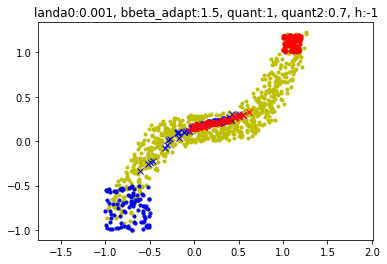

In [ ]:
gg=1.5
h=-1
g=0.001
q=1
qq=0.7
plot2(prueba2(g,gg,q,qq,h),g,gg,q,qq,h)

# Ej: Baricentro Euclideo

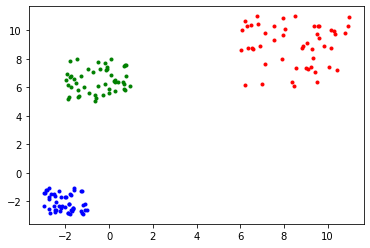

In [ ]:
x1=np.random.random((50,2))*2-3
x2=(np.random.random((50,2))*5+6)
x3=(np.random.random((50,2))*3-[2,-5])

dataeuclid=np.concatenate((x1,x2,x3),axis=0)

plt.plot(dataeuclid[:50,0],dataeuclid[:50,1],'.',c='b')
plt.plot(dataeuclid[50:100,0],dataeuclid[50:100,1],'.',c='r')
plt.plot(dataeuclid[100:150,0],dataeuclid[100:150,1],'.',c='g')
plt.show()

zz=np.matrix([0 for i in range(50)]+[1 for i in range(50)]+[2 for i in range(50)]).T

In [ ]:
def pruebaeucl(g):
    n_iter=100
    learningrate0=1
    landamax=1e6
    
    
    landa0=10
    beta_adapt=0.6


    h=g #Esto hace que el h se adapte a cada paso (con la formula de arriba pero con los y actuales, no fijado con los y_iniciales)!
    #h=g
    

    cost_function=euclidean_cost_fast
    
    #cost_function=my_fermat_cost2
    #cost_function=cero

    yinit=dataeuclid
    #yinit=np.zeros(samples.shape)+np.random.random(samples.shape)*0.00001
    
    monoton=True
    clb=False
    
    return barycenter(yinit,n_iter,dataeuclid,landa0,landamax,learningrate0,zz,h,beta_adapt,cost_function,landa_monotono=monoton,categorical=True,callback=clb)

In [ ]:
densidad=50
puntos1=50
dimension=2
def ploteucl(bari2,g):
    plt.plot(dataeuclid[:densidad,0],dataeuclid[:densidad,1],'.',c='b')
    plt.plot(dataeuclid[densidad:densidad+puntos1,0],dataeuclid[densidad:densidad+puntos1,1],'.',c='r')
    plt.plot(dataeuclid[densidad+puntos1:,0],dataeuclid[densidad+puntos1:,1],'.',c='g')
    plt.plot(bari2[:puntos1,0],bari2[:puntos1,1],'x',c='b')
    plt.plot(bari2[puntos1:densidad+puntos1,0],bari2[puntos1:densidad+puntos1,1],'x',c='r')
    plt.plot(bari2[densidad+puntos1:,0],bari2[puntos1+densidad:,1],'x',c='g')
    plt.axis('equal')
    plt.title('h='+str(g))
    plt.show()

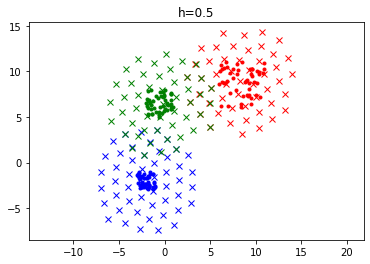

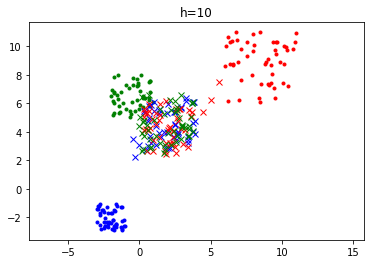

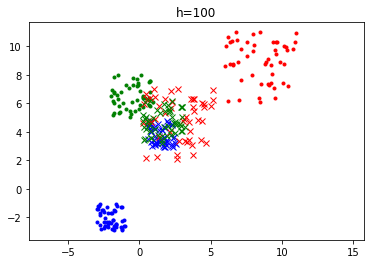

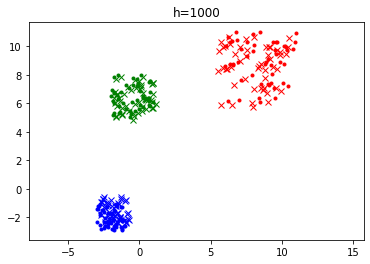

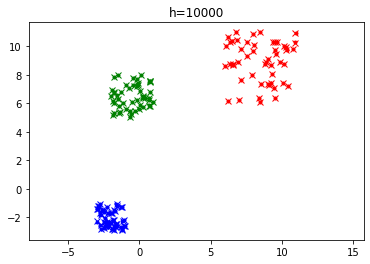

In [ ]:
for g in [.5,10,100,1000,10000]:
    ploteucl(pruebaeucl(g),g)

# Ej: principio de Fermat

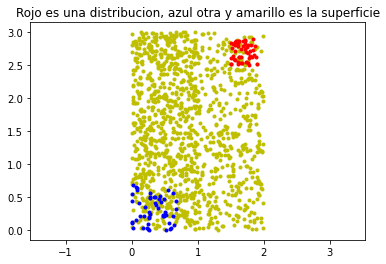

In [56]:
n=800

data1=np.random.random((n,2))*[1,3]
data2=np.random.random((n//2,2))*[1,3]+[1,0]
data=np.concatenate((data1,data2),axis=0)

n_samples=50

samples1=0.7*np.random.random((n_samples,2))
samples2=0.4*np.random.random((n_samples,2))+[1.5,2.5]
samples=np.concatenate((samples1,samples2),axis=0)



plt.plot(data[:,0],data[:,1],'.',c='y')
plt.plot(samples[n_samples:,0],samples[n_samples:,1],'.',c='r')
plt.plot(samples[:n_samples,0],samples[:n_samples,1],'.',c='b')
plt.axis('equal')
plt.title('Rojo es una distribucion, azul otra y amarillo es la superficie')
plt.show()

#data=np.concatenate((data,samples),axis=0)

In [65]:
z2=np.matrix([0 for i in range(n_samples)]+[1 for i in range(n_samples)]).T
#le pongo label 0 a la primera y 1 a la segunda

alpha2=5
k2=20
dimension2=2
f_dist2,tree2=fermat_graph(data,alpha=alpha2)

def my_fermat_cost2(x,initialData):
    return fermat_cost_cuad_fast(x,initialData,dimension2,f_dist2,tree2,data,k2,alpha2)

In [66]:
def prueba2(g,gg,q,qq,h):
    n_iter=100
    learningrate0=1
    landamax=1e3
    
    
    landa0=g
    beta_adapt=gg

    
    h=h
    quantil2=q
    q2=qq
    fctr=1
    #cost_function=euclidean_cost_fast
    def cero(a,b):
      return 0, np.zeros(a.shape)
    cost_function=my_fermat_cost2
    #cost_function=cero

    yinit=samples
    #yinit=np.zeros(samples.shape)+np.random.random(samples.shape)*0.00001
    
    monoton=True
    clb=True
    #clb=False
    
    return barycenter_fermat(yinit,n_iter,samples,landa0,landamax,learningrate0,z2,h,beta_adapt,cost_function,f_dist2,tree2,data,k2,alpha2,landa_monotono=monoton,factor=fctr,quant=quantil2,quant2=q2,categorical=True,callback=clb)

In [28]:
def plot2(bari2,g,gg,q,qq,h):
  plt.plot(data[:,0],data[:,1],'.',c='y')
  plt.plot(samples[n_samples:,0],samples[n_samples:,1],'.',c='r')
  plt.plot(samples[:n_samples,0],samples[:n_samples,1],'.',c='b')
  plt.plot(bari2[:n_samples,0],bari2[:n_samples,1],'x',c='b')
  plt.plot(bari2[n_samples:,0],bari2[n_samples:,1],'x',c='r')
  plt.axis('equal')
  plt.title('Rojo es una distribucion, azul otra y amarillo es la superficie')
  plt.title('landa0:'+str(g)+", bbeta_adapt:"+str(gg)+", quant:"+str(q)+", quant2:"+str(qq)+", h:"+str(h))
  plt.show()

In [64]:
gg=1.5
h=-1
g=0.001
q=1
qq=0.7
barialpha2=prueba2(g,gg,q,qq,h)

it: 0, paso: 0.14672261393029884, landa: 0.001, h:0.2926272735262184
it: 1, paso: 0.13830088544622662, landa: 0.001, h:0.29149335185195485
it: 2, paso: 0.13009888473887496, landa: 0.001, h:0.2888063271062016
it: 3, paso: 0.12342546866040652, landa: 0.001, h:0.2860958452203306
it: 4, paso: 0.1172970413029216, landa: 0.001, h:0.28615638577234814
it: 5, paso: 0.11124477822866756, landa: 0.001, h:0.2802465019379669
it: 6, paso: 0.10871108488995886, landa: 0.001, h:0.28086847101444656
it: 7, paso: 0.10043485403842103, landa: 0.001, h:0.25730646570476995
it: 8, paso: 1.5443214458907856e-15, landa: 0.001, h:0.25730646570476995
it: 9, paso: 0.1834801342790633, landa: 0.0015, h:0.2410762330560628
it: 10, paso: 0.18734092879173758, landa: 0.0015, h:0.23684472892640485
it: 11, paso: 0.18614820606516302, landa: 0.0015, h:0.23453441559620195
it: 12, paso: 0.08702492664691493, landa: 0.0015, h:0.23213872625568158
it: 13, paso: 0.010335411135122817, landa: 0.0015, h:0.23197346417040865
it: 14, paso: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 83, paso: 3.3957861491230346e-16, landa: 2.2168378200531005, h:0.07187065772528402


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 84, paso: 2.5757958714074285e-16, landa: 3.3252567300796505, h:0.07102237370105695


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 85, paso: 1.5659249896782013e-15, landa: 4.987885095119475, h:0.07053370381608307


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 86, paso: 1.1878092826660402e-15, landa: 7.481827642679213, h:0.0695050531771067


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 87, paso: 3.612472007784014e-15, landa: 11.222741464018819, h:0.06882331394407948


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 88, paso: 1.7183786571435964e-16, landa: 16.83411219602823, h:0.06848313632720664


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 89, paso: 2.0803158840068645e-15, landa: 25.251168294042344, h:0.06810735628703904


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 90, paso: 6.281320839358799e-15, landa: 37.876752441063516, h:0.06748947119245467


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 91, paso: 1.1885496147501924e-15, landa: 56.815128661595274, h:0.06663220239406156


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 92, paso: 9.036457851740156e-16, landa: 85.22269299239291, h:0.06607636553751264


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 93, paso: 6.8651780479583e-16, landa: 127.83403948858935, h:0.06584542071867408


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 94, paso: 4.148754388680319e-15, landa: 191.75105923288402, h:0.0656600522251455


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 95, paso: 2.4990405882862053e-14, landa: 287.626588849326, h:0.06547741931999863


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 96, paso: 1.1755489417399027e-15, landa: 431.43988327398904, h:0.06509792049865883


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 97, paso: 3.5462795080480996e-15, landa: 647.1598249109836, h:0.06463354962174049


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 98, paso: 5.363591245162553e-15, landa: 970.7397373664754, h:0.0640280229376069


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 99, paso: 2.5411913605869835e-16, landa: 1456.1096060497132, h:0.06364755169405029


In [67]:
gg=1.5
h=-1
g=0.001
q=1
qq=0.7
barialpha5=prueba2(g,gg,q,qq,h)

it: 0, paso: 0.9665752321784546, landa: 0.001, h:9.89840943144046e-05
it: 1, paso: 0.6886609797894417, landa: 0.001, h:8.569087990878051e-05
it: 2, paso: 0.8704848882502217, landa: 0.001, h:8.000555923454758e-05
it: 3, paso: 0.8543078505925735, landa: 0.001, h:7.674343724202483e-05
it: 4, paso: 0.812312467845524, landa: 0.001, h:7.498229903827812e-05
it: 5, paso: 1.0395576713697021, landa: 0.001, h:7.386047942779757e-05
it: 6, paso: 0.870376455564722, landa: 0.001, h:7.077595010128377e-05
it: 7, paso: 0.7774235519178888, landa: 0.001, h:6.807565145813347e-05
it: 8, paso: 0.9949160283817643, landa: 0.001, h:6.332727936288711e-05
it: 9, paso: 0.7543357688911367, landa: 0.001, h:5.877751315165311e-05
it: 10, paso: 0.6439058876528317, landa: 0.001, h:5.846834432108208e-05
it: 11, paso: 0.7048969383988754, landa: 0.001, h:4.3317144931336625e-05
it: 12, paso: 0.6747861187561144, landa: 0.001, h:4.237919517452277e-05
it: 13, paso: 0.6127788490127624, landa: 0.001, h:3.7437082388953774e-05
it:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 47, paso: 1.316656405366952e-16, landa: 0.43789389038085935, h:1.0490782883577093e-05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 48, paso: 2.1516061066350523e-16, landa: 0.656840835571289, h:1.0310076363312522e-05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


it: 49, paso: 1.8126876676299668e-16, landa: 0.9852612533569336, h:1.018435472886982e-05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 50, paso: 7.179122530640757e-17, landa: 1.4778918800354004, h:9.998528821846601e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 51, paso: 2.25344702054479e-16, landa: 2.2168378200531005, h:9.922328931915184e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 52, paso: 1.7869421072287504e-16, landa: 3.3252567300796505, h:9.795976572324248e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 53, paso: 2.759868883611257e-16, landa: 4.987885095119475, h:9.675393222994639e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 54, paso: 2.1623350382041454e-16, landa: 7.481827642679213, h:9.586262136653585e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 55, paso: 1.6895563629910648e-16, landa: 11.222741464018819, h:9.524775911567619e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 56, paso: 2.613083234265276e-16, landa: 16.83411219602823, h:9.510403013444469e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 57, paso: 1.9992293228521693e-16, landa: 25.251168294042344, h:9.495955135060383e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 58, paso: 7.536866042541024e-17, landa: 37.876752441063516, h:9.405747207404398e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 59, paso: 1.1412569481848967e-16, landa: 56.815128661595274, h:9.341367574200194e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 60, paso: 8.837931340166633e-17, landa: 85.22269299239291, h:9.26026211526102e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 61, paso: 2.7186691303000244e-16, landa: 127.83403948858935, h:9.181198457014556e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 62, paso: 1.0512312279224476e-16, landa: 191.75105923288402, h:9.027679163833468e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 63, paso: 1.632131684070515e-16, landa: 287.626588849326, h:8.952748304889743e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 64, paso: 2.588340047490594e-16, landa: 431.43988327398904, h:8.891808204277157e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 65, paso: 1.99857992014408e-16, landa: 647.1598249109836, h:8.81869566195464e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 66, paso: 1.5370104297537135e-16, landa: 970.7397373664754, h:8.75279795978401e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid do

it: 67, paso: 1.1870703026549908e-16, landa: 1456.1096060497132, h:8.700988763363448e-06


In [60]:
gg=1.5
h=-1
g=0.001
q=1
qq=0.7
barialpha1=prueba2(g,gg,q,qq,h)

it: 0, paso: 1.0586198267441138, landa: 0.001, h:3.4297043368478173
it: 1, paso: 0.00021482786849257238, landa: 0.001, h:3.429745665929549
it: 2, paso: 4.1166987039848664e-10, landa: 0.001, h:3.4297456660087553
it: 3, paso: 3.945883537207292e-10, landa: 0.0015, h:3.1711048262301986
it: 4, paso: 0.9859393719941583, landa: 0.0022500000000000003, h:3.0055541156230463
it: 5, paso: 0.026140487346546525, landa: 0.0022500000000000003, h:3.005498777420894
it: 6, paso: 0.0063191852433861955, landa: 0.0022500000000000003, h:3.006003848153026
it: 7, paso: 9.096947311092151e-14, landa: 0.0022500000000000003, h:3.0060038481530293
it: 8, paso: 0.5382335471280014, landa: 0.0033750000000000004, h:2.91040869715565
it: 9, paso: 0.19699533871525313, landa: 0.0033750000000000004, h:2.9018041605481533
it: 10, paso: 0.15787468566004725, landa: 0.0033750000000000004, h:2.8960586012798557
it: 11, paso: 1.6584063084906426e-15, landa: 0.0033750000000000004, h:2.8960586012798557
it: 12, paso: 1.3731231412232285,

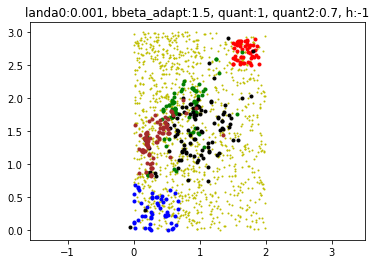

In [74]:
plt.plot(data[:,0],data[:,1],'.',c='y',markersize=2)
plt.plot(samples[n_samples:,0],samples[n_samples:,1],'.',c='r')
plt.plot(samples[:n_samples,0],samples[:n_samples,1],'.',c='b')
plt.plot(barialpha2[:,0],barialpha2[:,1],'.',c='g')
plt.plot(barialpha1[:,0],barialpha1[:,1],'.',c='black')
plt.plot(barialpha5[:,0],barialpha5[:,1],'.',c='brown')
plt.axis('equal')
plt.title('Rojo es una distribucion, azul otra y amarillo es la superficie')
plt.title('landa0:'+str(g)+", bbeta_adapt:"+str(gg)+", quant:"+str(q)+", quant2:"+str(qq)+", h:"+str(h))
plt.show()